**A stock prices predictor determines the performance of a company and foretells future stock prices.**

**A time series is an interpretation of event occurrences over a span of time. A time series is investigated to recognize patterns so that future incidents can be foretold on the basis of trends witnessed over a span of time. Some of the models that can be applied for time series forecasting include ARIMA (autoregressive integrated moving average), moving average, and exponential smoothing.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('/content/^NSEBANK.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-31,35615.300781,35881.949219,35288.949219,35487.398438,35486.984375,149300.0
1,2022-06-01,35358.949219,35768.699219,35285.449219,35620.800781,35620.386719,100800.0
2,2022-06-02,35470.949219,35676.199219,35385.000000,35613.648438,35613.234375,140700.0
3,2022-06-03,35929.550781,35958.449219,35175.101563,35275.050781,35274.640625,104800.0
4,2022-06-06,35159.148438,35424.500000,35072.300781,35310.199219,35309.789063,100800.0


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,35487.398438,35487.398438,NaN
1,0.0,35554.099610,35554.099610,0.0
2,0.0,35573.949219,35573.949219,0.0
3,0.0,35499.224610,35499.224610,0.0
4,0.0,35461.419531,35461.419531,0.0
...,...,...,...,...
244,1.0,43820.083334,43766.241862,0.0
245,1.0,43864.366537,43823.487630,0.0
246,1.0,43921.449870,43893.204102,0.0
247,1.0,44013.324870,43946.770834,0.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 50000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 20: buy 1 units at price 33642.449219, total balance 16357.550781
day 61, sell 1 units at price 38987.148438, investment 15.886772 %, total balance 55344.699219,
day 65: buy 1 units at price 39421.000000, total balance 15923.699219
day 80, sell 1 units at price 39546.250000, investment 0.317724 %, total balance 55469.949219,
day 90: buy 1 units at price 39093.101563, total balance 16376.847656
day 140, sell 1 units at price 42617.949219, investment 9.016546 %, total balance 58994.796875,
day 148: buy 1 units at price 43203.101563, total balance 15791.695312
day 154, sell 1 units at price 42014.750000, investment -2.750616 %, total balance 57806.445312,
day 162: buy 1 units at price 42506.800781, total balance 15299.644531
day 166, sell 1 units at price 40345.300781, investment -5.085069 %, total balance 55644.945312,
day 175: buy 1 units at price 41554.300781, total balance 14090.644531
day 182, sell 1 units at price 40701.699219, investment -2.051777 %, total balance 54792.343750,

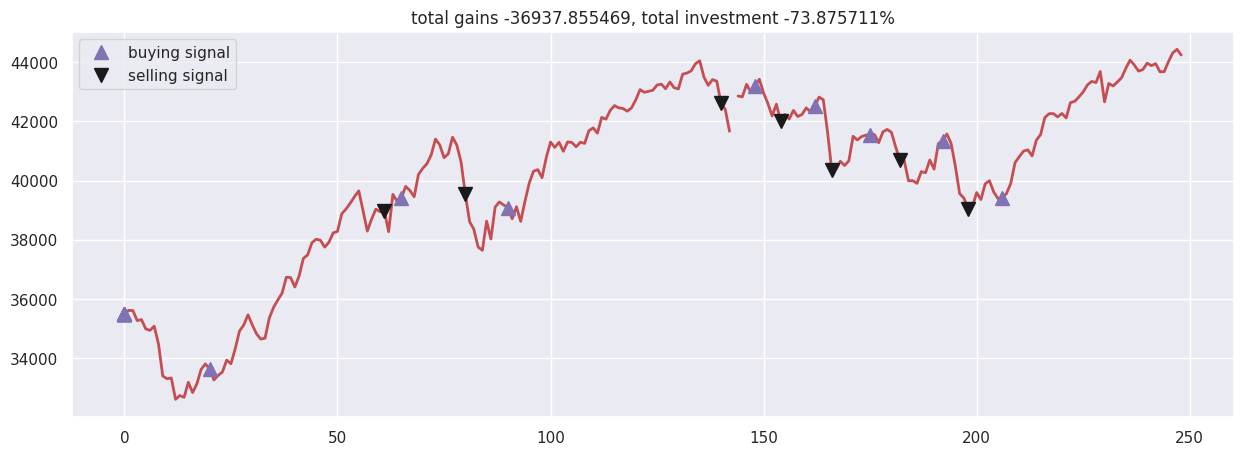

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()